In [1]:
# dataset = cifar10
# model = mobilenet
# optimizer = ADAM (0.001)
# loss = categorical_crossentropy
# batch_size = 32
# decay = l2 (0.01)
# augmentation = off
# validation_split = 0.2

In [2]:
import tensorflow as tf
import os
import numpy as np

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Input, Flatten, AveragePooling2D, Add
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
# https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L2

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist

In [3]:
batch_size=32
epochs=100
num_classes=10 
depth=20 

In [4]:
model_type = 'MobileNet%d' % (depth)

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train/255
x_test = x_test/255

print(x_train.shape)
print(x_test.shape)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
input_shape=x_train.shape[1:]

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [6]:
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 5
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 95
TRAINING_LR_MAX          = 0.001
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

In [7]:
def lr_schedule(epoch):
    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))
    # linear warmup followed by cosine decay
    
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)
        #max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))(math.pi/2.0))) + TRAINING_LR_FINAL
    # debug - learning rate display
    # print(epoch)
    # print(lr)
    return lr

In [8]:
#datagen = ImageDataGenerator(rotation_range=40, horizontal_flip=True, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05)
#augmented_data = datagen.flow(x_train[:40000], y_train[:40000])

In [9]:

# MODEL THAT CLAIMS TO PERFORM BETTER THAN "OVERFITTING MODEL" 

import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Activation, Conv2D, Dense, Dropout, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
# define the filter size
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


# define the calculation of each 'inverted Res_Block'
def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    prefix = 'block_{}_'.format(block_id)

    in_channels = inputs.shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs

    # Expand
    if block_id:
        x = Conv2D(expansion * in_channels, kernel_size=1, strides=1, padding='same', use_bias=False, activation=None, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'expand_BN')(x)
        x = ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None, use_bias=False, padding='same', kernel_initializer="he_normal", depthwise_regularizer=regularizers.l2(4e-5), name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'depthwise_BN')(x)
    x = ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters, kernel_size=1, strides=1, padding='same', use_bias=False, activation=None, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'project_BN')(x)


    if in_channels == pointwise_filters and stride == 1:
        return Add(name=prefix + 'add')([inputs, x])
    return x

#Create Build
def create_model(rows, cols, channels, level_0_blocks, level_1_blocks, level_2_blocks, num_classes, lr_initial):
  # encoder - input
    alpha=1.0
    include_top = True
    model_input = tf.keras.layers.Input(shape=(rows, cols, channels), name='input_image')
    x           = model_input

    first_block_filters = _make_divisible(32 * alpha, 8)

    # model architechture
    x = Conv2D(first_block_filters, kernel_size=3, strides=1, padding='same', use_bias=False, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name='Conv1')(model_input)

    x = _inverted_res_block(x, filters=16,  alpha=alpha, stride=1, expansion=1, block_id=0 )

    x = _inverted_res_block(x, filters=24,  alpha=alpha, stride=1, expansion=6, block_id=1 )
    x = _inverted_res_block(x, filters=24,  alpha=alpha, stride=1, expansion=6, block_id=2 )

    x = _inverted_res_block(x, filters=32,  alpha=alpha, stride=2, expansion=6, block_id=3 )
    x = _inverted_res_block(x, filters=32,  alpha=alpha, stride=1, expansion=6, block_id=4 )
    x = _inverted_res_block(x, filters=32,  alpha=alpha, stride=1, expansion=6, block_id=5 )

    x = _inverted_res_block(x, filters=64,  alpha=alpha, stride=2, expansion=6, block_id=6 )
    x = _inverted_res_block(x, filters=64,  alpha=alpha, stride=1, expansion=6, block_id=7 )
    x = _inverted_res_block(x, filters=64,  alpha=alpha, stride=1, expansion=6, block_id=8 )
    x = _inverted_res_block(x, filters=64,  alpha=alpha, stride=1, expansion=6, block_id=9 )
    x = Dropout(rate=0.25)(x)

    x = _inverted_res_block(x, filters=96,  alpha=alpha, stride=1, expansion=6, block_id=10)
    x = _inverted_res_block(x, filters=96,  alpha=alpha, stride=1, expansion=6, block_id=11)
    x = _inverted_res_block(x, filters=96,  alpha=alpha, stride=1, expansion=6, block_id=12)
    x = Dropout(rate=0.25)(x)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=13)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=14)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=15)
    x = Dropout(rate=0.25)(x)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, expansion=6, block_id=16)
    x = Dropout(rate=0.25)(x)


    # define filter size (last block)
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280


    x = Conv2D(last_block_filters, kernel_size=1, use_bias=False, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name='Conv_1')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name='Conv_1_bn')(x)
    x = ReLU(6., name='out_relu')(x)
    
    if include_top:
        x = GlobalAveragePooling2D(name='global_average_pool')(x)
        x = Dense(num_classes, activation='softmax', use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # create model of MobileNetV2 (for CIFAR-10)
    model = Model(inputs=model_input, outputs=x, name='mobilenetv2_cifar10')

    #model.compile(optimizer=tf.keras.optimizers.Adam(lr_initial), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=tf.keras.optimizers.Adam(lr_initial), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = create_model(rows=32, cols=32, channels=3, level_0_blocks=4, level_1_blocks=6, level_2_blocks=3, num_classes=10, lr_initial=0.001)
print(model.summary())
# reference for model 
# https://github.com/ruchi15/CNN-MobileNetV2-Cifar10/blob/master/CNN_Assignment_5_Design.ipynb

Model: "mobilenetv2_cifar10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         input_image[0][0]                
__________________________________________________________________________________________________
expanded_conv_depthwise (Depthw (None, 32, 32, 32)   288         Conv1[0][0]                      
__________________________________________________________________________________________________
expanded_conv_depthwise_BN (Bat (None, 32, 32, 32)   128         expanded_conv_depthwise[0][0]    
________________________________________________________________________________

In [10]:
# OVERFITTING MODEL 
'''
def mobilenet(input_size=(32, 32), l2_decay=0.1, N_CLASSES=10):
    """
    Builds the MobileNet model.
    :param tuple input_size: The height and width (in that order) of the
        model input.
    :param float l2_decay: The amount of L2 weight decay to add to the
        loss. Applies only to kernels, not biases.
    :return tensorflow.keras.Sequential: A MobileNet model.
    """

    model = Sequential()

    def _add_bn_relu():
        model.add(BatchNormalization(scale=False))
        model.add(ReLU())

    def _add_depthwise_block(strides=1):
        model.add(DepthwiseConv2D(
            (3, 3),
            strides=strides,
            padding='same',
            kernel_regularizer=L2(l2=l2_decay)))
        _add_bn_relu()

    def _add_pointwise_block(filters):
        model.add(Conv2D(filters, (1, 1), kernel_regularizer=L2(l2=l2_decay)))
        _add_bn_relu()

    model.add(Conv2D(
        32, (3, 3),
        strides=2,
        padding='same',
        kernel_regularizer=L2(l2=l2_decay),
        input_shape=input_size + (3,))) # change the channel dimension here
    _add_bn_relu()
    _add_depthwise_block()
    _add_pointwise_block(64)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(128)
    _add_depthwise_block()
    _add_pointwise_block(128)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(256)
    _add_depthwise_block()
    _add_pointwise_block(256)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(512)
    for _ in range(5):
        _add_depthwise_block()
        _add_pointwise_block(512)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(1024)
    _add_depthwise_block()
    _add_pointwise_block(1024)

    model.add(AveragePooling2D(pool_size=(input_size[0] // 32, input_size[1] // 32)))

    model.add(Flatten())
    model.add(Dense(N_CLASSES, kernel_regularizer=L2(l2=l2_decay)))
    model.add(Softmax())

    return model


model = mobilenet(input_size=(32, 32), l2_decay=0.001, N_CLASSES=10)
print(model.summary())
'''

'\ndef mobilenet(input_size=(32, 32), l2_decay=0.1, N_CLASSES=10):\n    """\n    Builds the MobileNet model.\n    :param tuple input_size: The height and width (in that order) of the\n        model input.\n    :param float l2_decay: The amount of L2 weight decay to add to the\n        loss. Applies only to kernels, not biases.\n    :return tensorflow.keras.Sequential: A MobileNet model.\n    """\n\n    model = Sequential()\n\n    def _add_bn_relu():\n        model.add(BatchNormalization(scale=False))\n        model.add(ReLU())\n\n    def _add_depthwise_block(strides=1):\n        model.add(DepthwiseConv2D(\n            (3, 3),\n            strides=strides,\n            padding=\'same\',\n            kernel_regularizer=L2(l2=l2_decay)))\n        _add_bn_relu()\n\n    def _add_pointwise_block(filters):\n        model.add(Conv2D(filters, (1, 1), kernel_regularizer=L2(l2=l2_decay)))\n        _add_bn_relu()\n\n    model.add(Conv2D(\n        32, (3, 3),\n        strides=2,\n        padding=\'

In [11]:
#model_tf = tf.keras.applications.mobilenet.MobileNet(input_shape=(32, 32, 3), weights=None, classes=10)
#print(model_tf.summary())

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [13]:
#steps = int(x_train.shape[0]/batch_size) 
callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_schedule)]
history = model.fit(x_train, y_train, epochs=epochs, verbose=1, validation_split=0.1, callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 68s 40ms/step - loss: 3.0554 - accuracy: 0.1417 - val_loss: 3.2419 - val_accuracy: 0.0950
Epoch 2/100
1407/1407 [==============================] - 54s 39ms/step - loss: 2.5887 - accuracy: 0.3231 - val_loss: 3.8091 - val_accuracy: 0.1058
Epoch 3/100
1407/1407 [==============================] - 54s 38ms/step - loss: 2.1134 - accuracy: 0.5032 - val_loss: 4.7731 - val_accuracy: 0.1038
Epoch 4/100
1407/1407 [==============================] - 54s 38ms/step - loss: 1.7695 - accuracy: 0.6093 - val_loss: 4.0005 - val_accuracy: 0.2292
Epoch 5/100
1407/1407 [==============================] - 53s 38ms/step - loss: 1.4932 - accuracy: 0.6826 - val_loss: 2.2935 - val_accuracy: 0.6010
Epoch 6/100
1407/1407 [==============================] - 53s 38ms/step - loss: 1.3200 - accuracy: 0.7175 - val_loss: 9.2939 - val_accuracy: 0.2164
Epoch 7/100
1407/1407 [==============================] - 54s 38ms/step - loss: 1.1409 - accuracy: 0.7531 - val_loss: 3

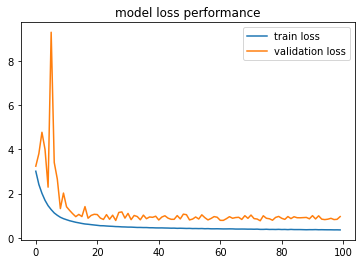

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss performance')
plt.legend(['train loss', 'validation loss'])
plt.show()

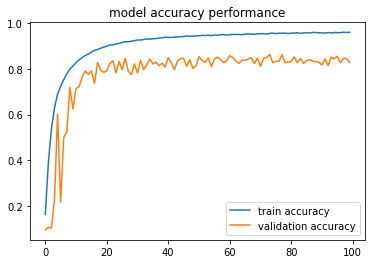

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy performance')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [16]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 1.0021 - accuracy: 0.8176


[1.0020743608474731, 0.8176000118255615]